In [1]:
import taj_mahal

import numpy as np
from numpy.typing import NDArray
from scipy.spatial import distance
from scipy.stats import chi2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
help(taj_mahal.distances)

Help on built-in function distances in module taj_mahal:

distances(...) method of builtins.PyCapsule instance
    distances(points: numpy.ndarray[numpy.float64]) -> numpy.ndarray

    Calculates Mahalanobis distances for a numerical dataset



In [3]:
help(taj_mahal.outliers)

Help on built-in function outliers in module taj_mahal:

outliers(...) method of builtins.PyCapsule instance
    outliers(points: numpy.ndarray[numpy.float64], alpha: float = 0.01, indices: bool = False) -> numpy.ndarray

    Returns outlier values or indices



In [4]:
np.random.seed(42)
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 2]], size=100)

In [5]:
dist = taj_mahal.distances(data)
dist[:10]

array([0.7413139 , 1.71284696, 0.29823191, 2.08968948, 0.66639405,
       0.63452498, 2.00793687, 1.95448142, 1.09402805, 1.69394263])

In [6]:
outliers, = taj_mahal.outliers(data)
outliers

array([-0.81324672, -3.87579204])

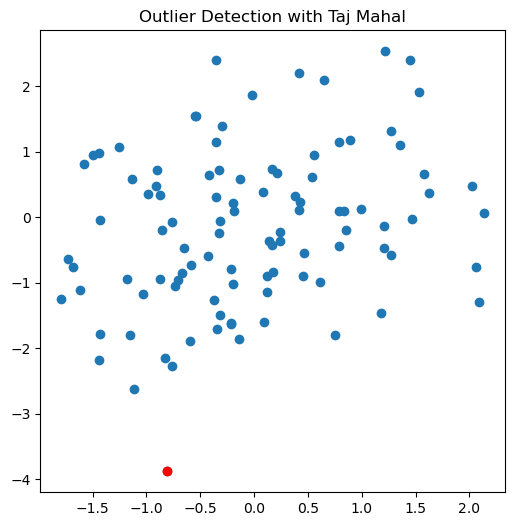

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(data[:, 0], data[:, 1])
plt.plot(outliers[0], outliers[1], 'ro')
plt.title('Outlier Detection with Taj Mahal')
plt.show()

## Comparison with Scipy

In [8]:
mu = np.mean(data, axis=0)
cov_inv = np.linalg.inv(np.cov(data, rowvar=False))

scipy_dist = [distance.mahalanobis(point, mu, cov_inv) for point in data]

In [9]:
df = pd.DataFrame({'taj_mahal': dist, 'scipy': scipy_dist})
df['difference'] = df['taj_mahal'] - df['scipy']
df = df.sort_values('difference', ascending=False)
df.head()

,taj_mahal,scipy,difference
62,2.285757,2.285757,1.332268e-15
56,2.435297,2.435297,8.881784e-16
60,1.442137,1.442137,4.440892e-16
85,1.221721,1.221721,4.440892e-16
27,1.588898,1.588898,4.440892e-16


In [10]:
e = df['difference'].to_numpy()
print(f'The data has a RMSE of {np.sqrt(sum(e * e) / len(e))}')

The data has a RMSE of 2.686418561506723e-16


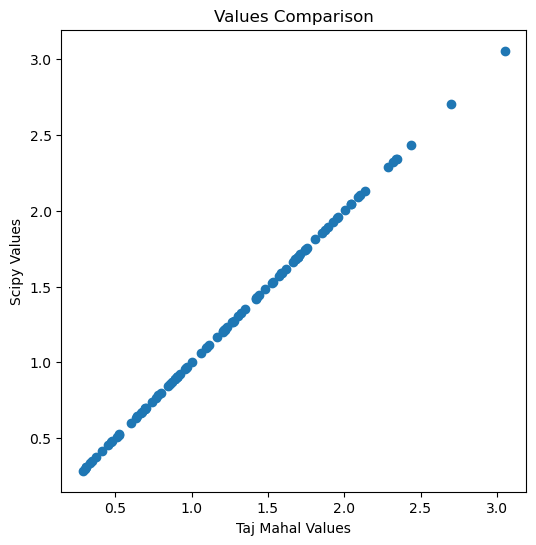

In [11]:
plt.figure(figsize=(6, 6))

plt.scatter(df['taj_mahal'], df['scipy'])
plt.title('Values Comparison')
plt.xlabel('Taj Mahal Values')
plt.ylabel('Scipy Values')

plt.show()

### Performance

In [12]:
%%timeit
[distance.mahalanobis(point, mu, cov_inv) for point in data]

470 μs ± 7.54 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
taj_mahal.distances(data)

11 μs ± 77.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
def scipy_outliers(data: NDArray, alpha=0.01):
    threshold = np.sqrt(chi2.ppf(1 - alpha, data.shape[1]))
    
    mu = np.mean(data, axis=0)
    cov_inv = np.linalg.inv(np.cov(data, rowvar=False))
    
    distances = np.array([distance.mahalanobis(point, mu, cov_inv) for point in data])
    
    return data[np.where(distances > threshold)]

In [15]:
%%timeit
_ = scipy_outliers(data)

666 μs ± 5.55 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
_ = taj_mahal.outliers(data)

12.7 μs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
